In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

import thesis
chapter = 'theory'
save = True

In [2]:
from kid_readout.measurement.io import npy
from kid_readout.analysis.resonator import lmfit_resonator

In [3]:
npd = npy.NumpyDirectory('/data/detectors/2016-10-18_124841_sweep_stream_on_off/')

In [4]:
lo_index = 5
attenuation_index = 2

measurements_per_sss = 4 # SingleSweepStream, SingleSweep, SingleStream, ADCSnap
num_attenuations = 4
index = measurements_per_sss * (lo_index * num_attenuations + attenuation_index) 
sss = npd.read('SingleSweepStream{}'.format(index))

In [5]:
sss.state.lo_index == lo_index

True

In [6]:
sss.stream.roach_state.dac_attenuation

40.0

In [7]:
# Re-fit the resonator
sss.sweep.fit_resonator(model=lmfit_resonator.LinearLossResonatorWithCable)

In [8]:
sss.resonator.asymmetry

0.29488775821401703

In [9]:
print("f_r = {:.1f} GHz".format(1e-9 * sss.resonator.f_0))

f_r = 3.5 GHz


In [10]:
print("The sweep spans {:.1f} MHz".format(1e-6 * sss.resonator.frequency.ptp()))

The sweep spans 2.0 MHz


In [11]:
print("loss_i = {:.2g} = 1 / {:.0f}".format(sss.resonator.loss_i, 1 / sss.resonator.loss_i))

loss_i = 8.9e-06 = 1 / 112374


In [12]:
print("loss_c = {:.2g} = 1 / {:.0f}".format(sss.resonator.loss_c, 1 / sss.resonator.loss_c))

loss_c = 3.2e-05 = 1 / 30853


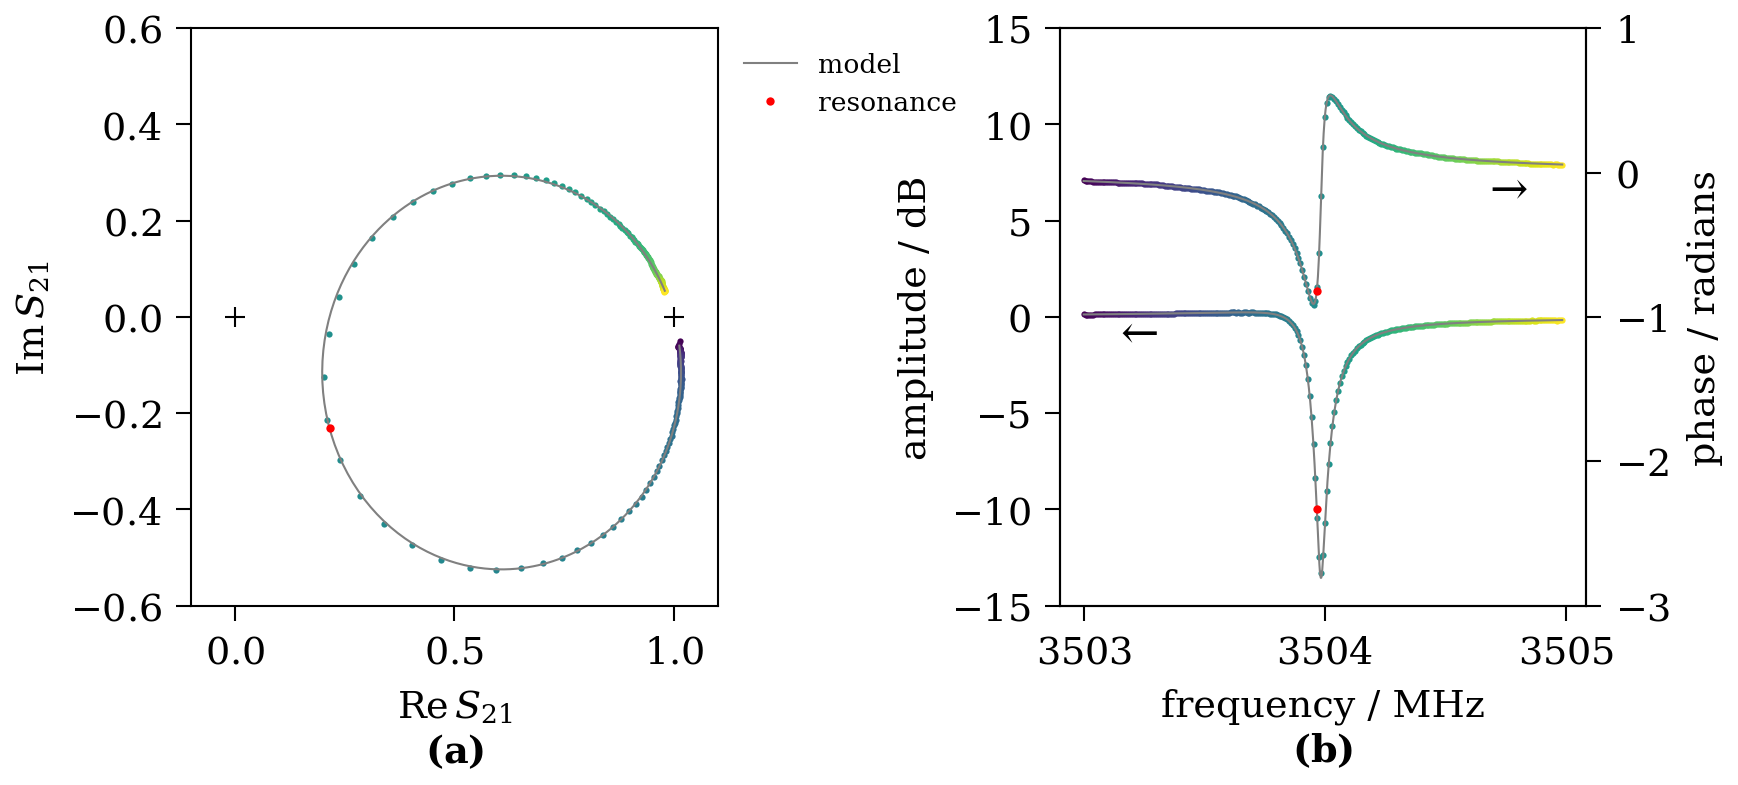

In [13]:
fig, (ax_complex, ax_amp) = plt.subplots(1, 2, figsize=(6, 2.5), gridspec_kw={'wspace': 0.65})
ax_phi = ax_amp.twinx()

ax_complex.set_xlabel('$\\mathrm{{Re}} \\, S_{{21}}$' + '\n' + '${{\\bf (a)}}$')
ax_complex.set_ylabel('$\\mathrm{{Im}} \\, S_{{21}}$')
ax_amp.set_xlabel('frequency / MHz' + '\n' + '${{\\bf (b)}}$')
ax_amp.set_ylabel('amplitude / dB')
ax_phi.set_ylabel('phase / radians')

model_color = 'gray'
resonance_color = 'red'
f_scale = 1e-6

normalized = sss.resonator.extract(normalize=True)
mappable = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=normalized.f_data.min(),
                                                           vmax=normalized.f_data.max()),
                                 cmap=plt.cm.viridis)

for f, s21 in zip(normalized.f_data, normalized.s21_data):
    ax_complex.plot(s21.real, s21.imag, '.', color=mappable.to_rgba(f))
    ax_amp.plot(f_scale * f, 20 * np.log10(np.abs(s21)), '.', color=mappable.to_rgba(f))
    ax_phi.plot(f_scale * f, np.angle(s21), '.', color=mappable.to_rgba(f))

ax_complex.plot(normalized.s21_model.real, normalized.s21_model.imag, color=model_color, label='model')
ax_complex.plot(normalized.s21_0.real, normalized.s21_0.imag,
             '.', markersize=4, color=resonance_color, label='resonance')
ax_complex.plot(0, 0, '+', markersize=5, markeredgewidth=0.5, color='black')
ax_complex.plot(1, 0, '+', markersize=5, markeredgewidth=0.5, color='black')

ax_amp.plot(f_scale * normalized.f_model, 20 * np.log10(np.abs(normalized.s21_model)), color=model_color)
ax_phi.plot(f_scale * normalized.f_model, np.angle(normalized.s21_model), color=model_color)
ax_amp.plot(f_scale * normalized.f_0, 20 * np.log10(np.abs(normalized.s21_0)),
             '.', markersize=4, color=resonance_color)
ax_phi.plot(f_scale * normalized.f_0, np.angle(normalized.s21_0),
             '.', markersize=4, color=resonance_color)

ax_amp.text(0.1, 0.45, r'$\leftarrow$', color='black', transform=ax_amp.transAxes)
ax_phi.text(0.8, 0.7, r'$\rightarrow$', color='black', transform=ax_phi.transAxes)

ax_complex.set_xlim(-0.1, 1.1)
ax_complex.set_ylim(-0.6, 0.6)
ax_amp.set_ylim(-15, 15)
ax_phi.set_ylim(-3, 1)
ax_complex.legend(fontsize='xx-small', loc='upper right', bbox_to_anchor=(1.5, 1))

if save:
    fig.savefig(thesis.full_filename(chapter, 'example_resonator_fit_amplitude_phase_and_normalized.pdf'))